## Hand writting (Digit) classification

In [1]:
from collections import defaultdict
import os, glob, random, sys, time, keras, cv2, itertools, sklearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.utils.fixes import signature
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.models import *
from keras.layers import *

C:\Users\kamru\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#load mnist dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# Printing the shape of the Train and test Data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
cDir=os.getcwd()
for i in range(len(X_test)):
    image=X_test[i,:,:]
    img=image.reshape(28,28)
    number='%04d'%i
    path=cDir+'/test/'+str(number)+'.png'
    cv2.imwrite(path,img)

In [5]:
# Comments
# There are 60000 images in Training with the size 28x28
# There are 10000 images in Test with the size 28x28

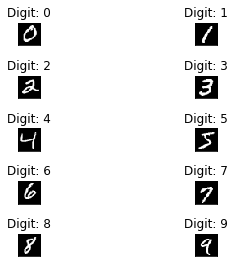

In [6]:
# Plot 0~9 Hand written digits for understanding
x=np.unique(y_train)
unique=[]

for i in range(len(x)):
    number=x[i]
    for j in range(len(y_train)):
        getNumber=y_train[j]
        if getNumber==number:
            unique.append(j)
            break
            
fig = plt.figure()
for i in range(len(unique)):
    index=unique[i]
    plt.subplot(5,2,i+1)
    plt.tight_layout()
    plt.imshow(X_train[index], cmap='gray', interpolation='none')
    plt.title("Digit: {}".format(y_train[index]))
    plt.xticks([])
    plt.yticks([])


## Create the model with the VGG16

In [7]:
##model building
input_shape=(28,28,1)
model = Sequential()

#convolutional layer with rectified linear unit activation
model.add(Conv2D(32,
                 kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

#32 convolution filters used each of size 3x3
#again

model.add(Conv2D(64, 
                 kernel_size=(3, 3),
                 activation='relu'))

model.add(Conv2D(128, 
                 kernel_size=(3, 3),
                 activation='relu'))

#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

#randomly turn neurons on and off to improve convergence
model.add(Dropout(0.25))

#flatten since too many dimensions, we only want a classification output
model.add(Flatten())

#fully connected to get all relevant data
model.add(Dense(128, activation='relu'))

#one more dropout for convergence' sake :) 
model.add(Dropout(0.5))

#output a softmax to squash the matrix into output probabilities
model.add(Dense(10, activation='softmax'))

In [8]:
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

for i, layer in enumerate(model.layers):
    print(i, layer.name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15488)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1982592   
__________

In [9]:
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

#more reshaping
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape) 
#X_train shape: (60000, 28, 28, 1)
# convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

X_train shape: (60000, 28, 28, 1)


In [10]:
batch_size = 128
num_epoch = 20

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epoch,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 14s 242us/step - loss: 0.1948 - acc: 0.9395 - val_loss: 0.0432 - val_acc: 0.9856
Epoch 2/20
60000/60000 [==============================] - 12s 195us/step - loss: 0.0735 - acc: 0.9785 - val_loss: 0.0303 - val_acc: 0.9896
Epoch 3/20
60000/60000 [==============================] - 12s 195us/step - loss: 0.0541 - acc: 0.9840 - val_loss: 0.0249 - val_acc: 0.9922
Epoch 4/20
60000/60000 [==============================] - 12s 196us/step - loss: 0.0414 - acc: 0.9875 - val_loss: 0.0254 - val_acc: 0.9920
Epoch 5/20
60000/60000 [==============================] - 12s 195us/step - loss: 0.0374 - acc: 0.9882 - val_loss: 0.0297 - val_acc: 0.9900
Epoch 6/20
60000/60000 [==============================] - 12s 194us/step - loss: 0.0305 - acc: 0.9905 - val_loss: 0.0247 - val_acc: 0.9930
Epoch 7/20
60000/60000 [==============================] - 12s 195us/step - loss: 0.0268 - acc: 0.9917 - val_loss: 0.

In [11]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0]) #Test loss: 0.0296396646054
print('Test accuracy:', score[1]) #Test accuracy: 0.9904

# 10000/10000 [==============================] - 1s 76us/step
# Test loss: 0.030457835188111265
# Test accuracy: 0.993

10000/10000 [==============================] - 1s 111us/step
Test loss: 0.02899697165951661
Test accuracy: 0.9929


C:\Users\kamru\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


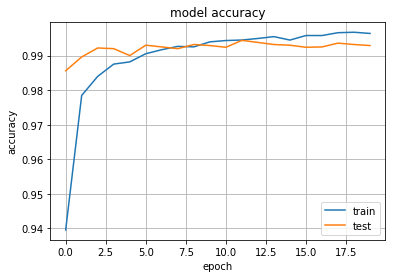

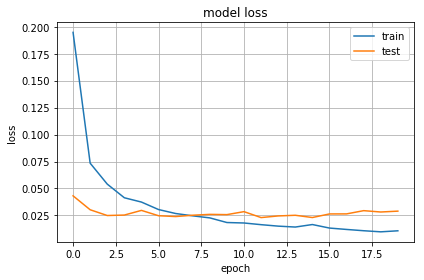

In [12]:
# plotting the metrics
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid('on')
plt.legend(['train', 'test'], loc='lower right')



plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.grid('on')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()